In [1]:
import torch

from clipseg.models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt


# load model
model = CLIPDensePredT(version="ViT-B/16", reduce_dim=64)
model.eval()

# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(
    torch.load("clipseg/weights/rd64-uni.pth", map_location=torch.device("cuda")),
    strict=False,
)

_IncompatibleKeys(missing_keys=['clip_model.positional_embedding', 'clip_model.text_projection', 'clip_model.logit_scale', 'clip_model.visual.class_embedding', 'clip_model.visual.positional_embedding', 'clip_model.visual.proj', 'clip_model.visual.conv1.weight', 'clip_model.visual.ln_pre.weight', 'clip_model.visual.ln_pre.bias', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_weight', 'clip_model.visual.transformer.resblocks.0.attn.in_proj_bias', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.weight', 'clip_model.visual.transformer.resblocks.0.attn.out_proj.bias', 'clip_model.visual.transformer.resblocks.0.ln_1.weight', 'clip_model.visual.transformer.resblocks.0.ln_1.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_fc.bias', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.weight', 'clip_model.visual.transformer.resblocks.0.mlp.c_proj.bias', 'clip_model.visual.transformer.resblocks.0.ln_2.weight',

In [17]:
# load and normalize image
input_image = Image.open("./dataset/WildBees/Andrena_fulva_24828677_1.jpg")

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((512, 512)),
    ]
)
img = transform(input_image).unsqueeze(0)


torch.Size([512, 512])


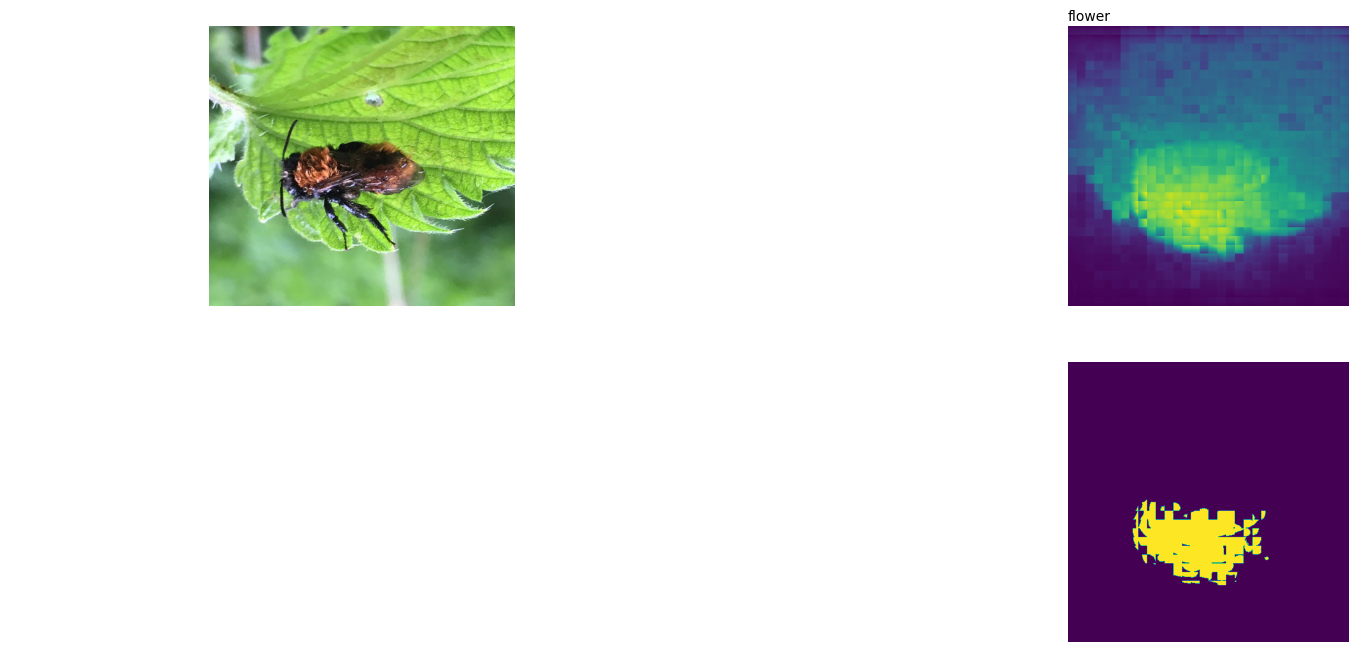

In [20]:
# prompts = ["bee", "insect", "something can fly", "flower", "something to eat"]
prompts = ["flower"]
length = len(prompts)

# predict
with torch.no_grad():
    preds = model(img.repeat(length, 1, 1, 1), prompts)[0]

print(preds[0][0].shape)

preds = torch.sigmoid(preds)
threshold = 0.4
one = torch.ones_like(preds)
zero = torch.zeros_like(preds)
preds_bi = torch.where(preds <= threshold, zero, one)


# visualize prediction
_, ax = plt.subplots(2, length + 1, figsize=(20, 8))
[a.axis("off") for a in ax.flatten()]
ax[0][0].imshow(input_image)
[ax[0][i + 1].imshow(preds[i][0]) for i in range(length)]
[ax[0][i + 1].text(0, -10, prompts[i]) for i in range(length)]
[ax[1][i + 1].imshow(preds_bi[i][0]) for i in range(length)]